In [6]:
merged

,strike,IV_call,IV_put
0,500.0,0.000010,0.500005
1,530.0,0.000010,0.500005
2,535.0,0.000010,0.500005
3,540.0,0.000010,0.500005
4,550.0,0.000010,0.500005
...,...,...,...
94,735.0,0.250007,0.000010
95,740.0,0.250007,0.000010
96,745.0,0.250007,0.000010
97,750.0,0.500005,0.000010


/var/folders/7v/53v6_s_j22jgxn1yq73tgjyc0000gn/T/ipykernel_26501/1175453719.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(t, start="2023-01-01", end=datetime.today().strftime("%Y-%m-%d"))
[*********************100%***********************]  1 of 1 completed
/var/folders/7v/53v6_s_j22jgxn1yq73tgjyc0000gn/T/ipykernel_26501/1175453719.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(t, start="2023-01-01", end=datetime.today().strftime("%Y-%m-%d"))
[*********************100%***********************]  1 of 1 completed
/var/folders/7v/53v6_s_j22jgxn1yq73tgjyc0000gn/T/ipykernel_26501/1175453719.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(t, start="2023-01-01", end=datetime.today().strftime("%Y-%m-%d"))
[*********************100%***********************]  1 of 1 completed
/var/folders/7v/53v6_s_j22jgxn1yq73tgjyc0000gn/T/ipyker

Put-Call Ratio (Volume): 1.37
Put-Call Ratio (Open Interest): nan


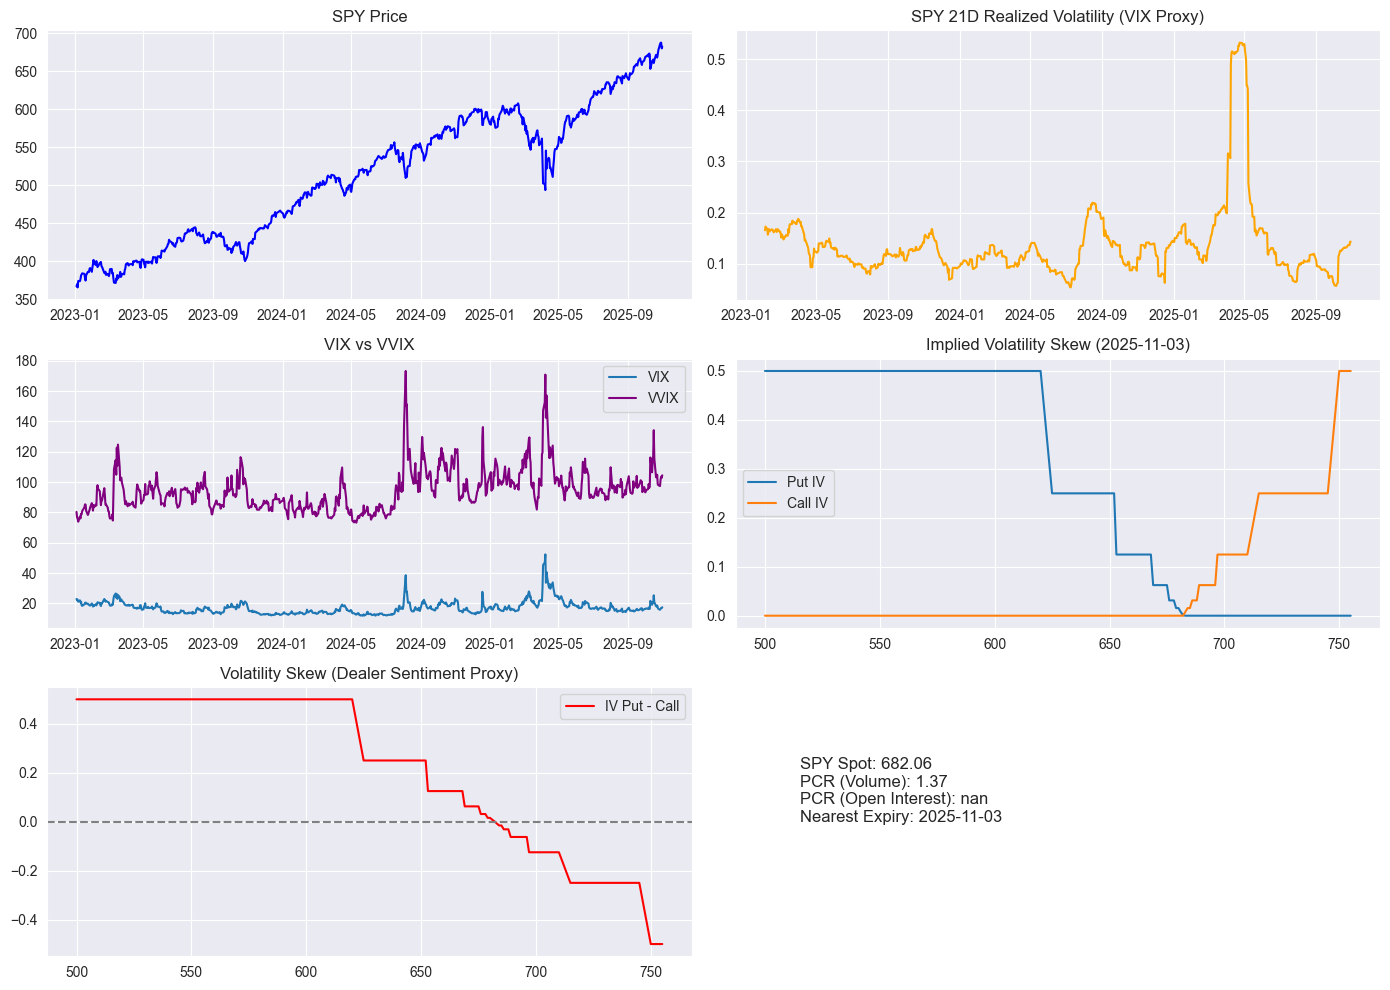

In [1]:
# SPY OPTIONS & VOLATILITY EDA USING YFINANCE
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# 1. Download tickers separately to avoid MultiIndex
tickers = ["SPY", "^VIX", "^VVIX"]
adj_close = pd.DataFrame()

for t in tickers:
    df = yf.download(t, start="2023-01-01", end=datetime.today().strftime("%Y-%m-%d"))

    if "Adj Close" in df.columns:
        adj_close[t] = df["Adj Close"]
    elif "Close" in df.columns:
        adj_close[t] = df["Close"]
    else:
        raise ValueError(f"No Close data available for ticker {t}")


# Compute SPY returns & realized volatility
adj_close["SPY_ret"] = adj_close["SPY"].pct_change()
adj_close["SPY_realized_vol"] = adj_close["SPY_ret"].rolling(21).std() * np.sqrt(252)

# 2. Get SPY Option Chain (nearest expiry)
spy = yf.Ticker("SPY")
expirations = spy.options
if not expirations:
    raise ValueError("No options found for SPY. Check your yfinance connection.")
next_expiry = expirations[0]  # closest expiry
option_chain = spy.option_chain(next_expiry)
calls = option_chain.calls.copy()
puts = option_chain.puts.copy()

# Add mid IV (yfinance already provides impliedVolatility)
calls["mid_iv"] = calls["impliedVolatility"]
puts["mid_iv"] = puts["impliedVolatility"]

# ATM Strike approximation
spot = adj_close["SPY"].iloc[-1]
calls["moneyness"] = calls["strike"] / spot
puts["moneyness"] = puts["strike"] / spot

# 3. Compute Put–Call Ratios
pcr_volume = puts["volume"].sum() / calls["volume"].sum()
pcr_oi = puts["openInterest"].sum() / calls["openInterest"].sum()

print(f"Put-Call Ratio (Volume): {pcr_volume:.2f}")
print(f"Put-Call Ratio (Open Interest): {pcr_oi:.2f}")

# 4. Compute IV Skew (Put IV - Call IV)
merged = pd.merge(
    calls[["strike", "impliedVolatility"]].rename(columns={"impliedVolatility": "IV_call"}),
    puts[["strike", "impliedVolatility"]].rename(columns={"impliedVolatility": "IV_put"}),
    on="strike",
    how="inner"
)
merged["skew"] = merged["IV_put"] - merged["IV_call"]

# 5. Plot Dashboard
fig, axes = plt.subplots(3, 2, figsize=(14, 10))

# SPY Price
axes[0,0].plot(adj_close.index, adj_close["SPY"], color="blue")
axes[0,0].set_title("SPY Price")

# Realized Volatility
axes[0,1].plot(adj_close.index, adj_close["SPY_realized_vol"], color="orange")
axes[0,1].set_title("SPY 21D Realized Volatility (VIX Proxy)")

# VIX and VVIX
axes[1,0].plot(adj_close.index, adj_close["^VIX"], label="VIX")
axes[1,0].plot(adj_close.index, adj_close["^VVIX"], label="VVIX", color="purple")
axes[1,0].set_title("VIX vs VVIX")
axes[1,0].legend()

# IV Skew Curve
axes[1,1].plot(merged["strike"], merged["IV_put"], label="Put IV")
axes[1,1].plot(merged["strike"], merged["IV_call"], label="Call IV")
axes[1,1].set_title(f"Implied Volatility Skew ({next_expiry})")
axes[1,1].legend()

# Skew Differential
axes[2,0].plot(merged["strike"], merged["skew"], label="IV Put - Call", color="red")
axes[2,0].axhline(0, color="gray", linestyle="--")
axes[2,0].set_title("Volatility Skew (Dealer Sentiment Proxy)")
axes[2,0].legend()

# Summary Info
axes[2,1].axis("off")
axes[2,1].text(0.1, 0.5,
    f"SPY Spot: {spot:.2f}\nPCR (Volume): {pcr_volume:.2f}\nPCR (Open Interest): {pcr_oi:.2f}\nNearest Expiry: {next_expiry}",
    fontsize=12
)

plt.tight_layout()
plt.show()

/var/folders/7v/53v6_s_j22jgxn1yq73tgjyc0000gn/T/ipykernel_26501/103149162.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(t, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
/var/folders/7v/53v6_s_j22jgxn1yq73tgjyc0000gn/T/ipykernel_26501/103149162.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(t, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
/var/folders/7v/53v6_s_j22jgxn1yq73tgjyc0000gn/T/ipykernel_26501/103149162.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(t, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
/var/folders/7v/53v6_s_j22jgxn1yq73tgjyc0000gn/T/ipykernel_26501/103149162.py:40: RuntimeWarning: invalid value encountered in scalar divide
  pcr_oi = puts["openInterest"].sum() / 

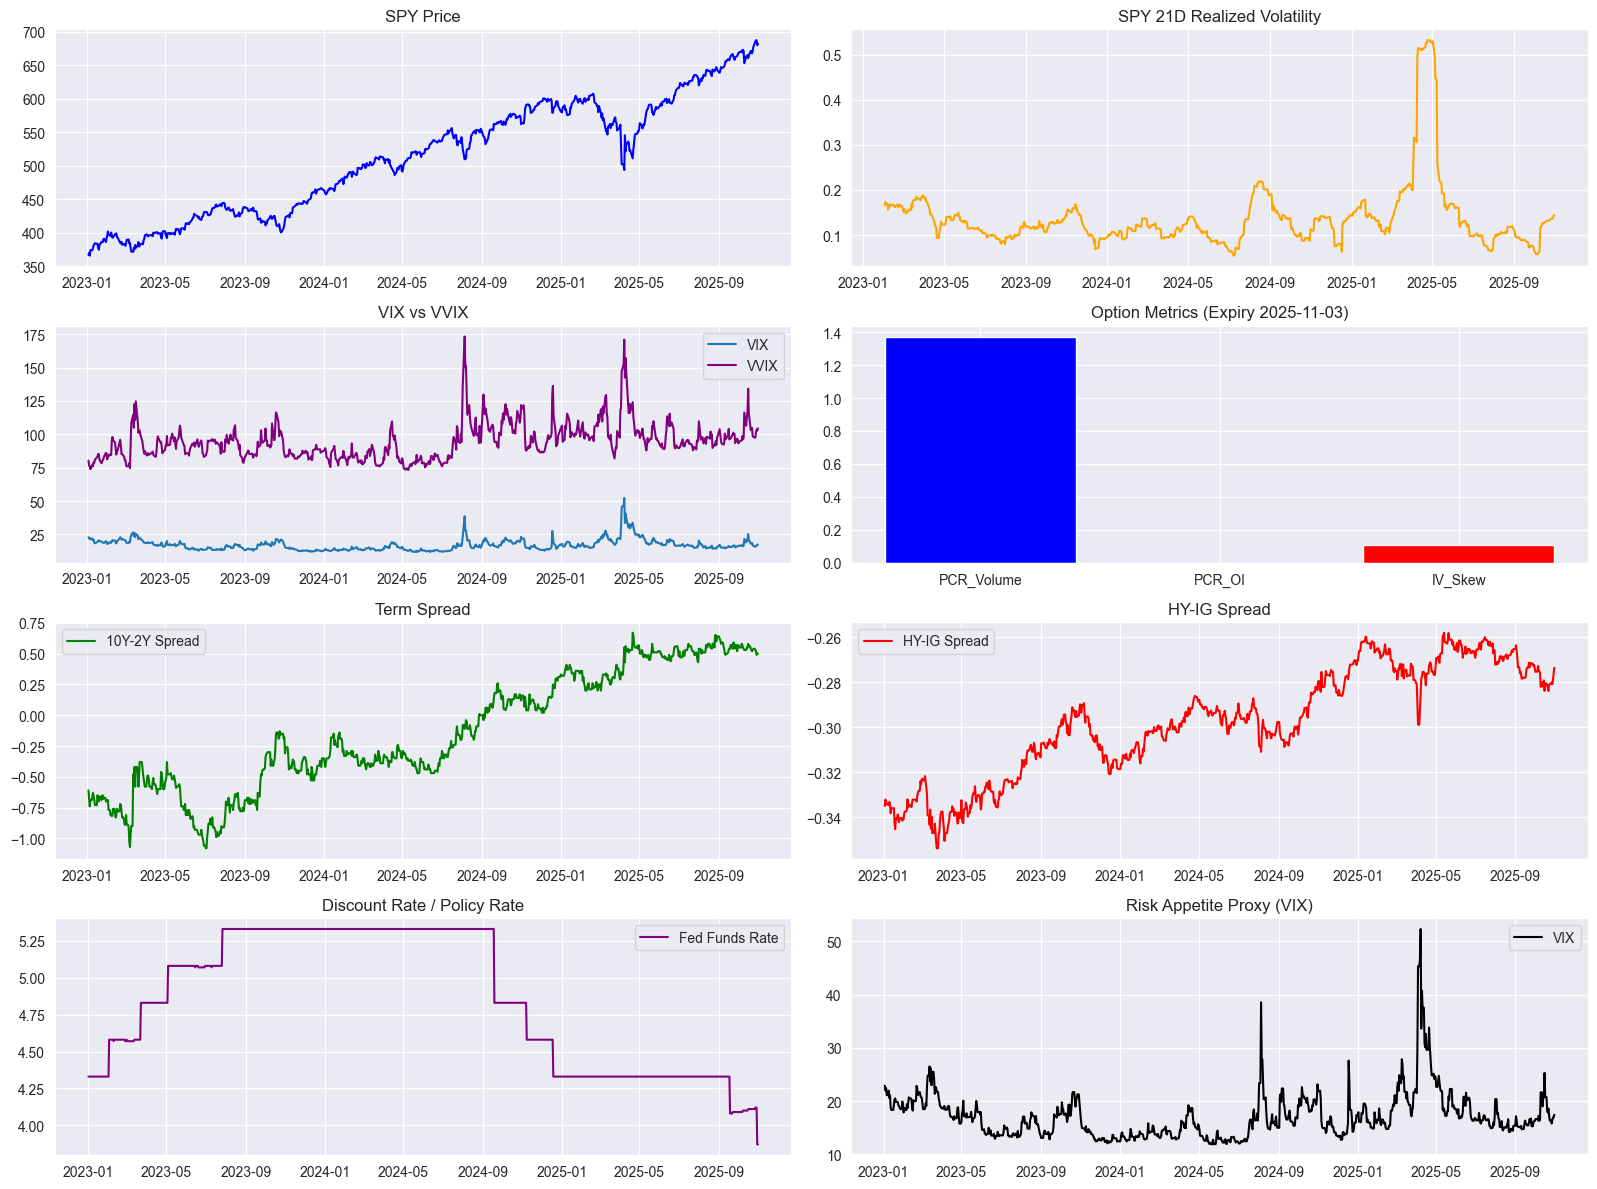

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import pandas_datareader.data as web
import datetime

# 1. Dates
start = "2023-01-01"
end = datetime.datetime.today().strftime("%Y-%m-%d")

# 2. Download daily market prices
tickers = ["SPY", "^VIX", "^VVIX"]
adj_close = pd.DataFrame()

for t in tickers:
    df = yf.download(t, start=start, end=end)
    # tz-naive
    df.index = df.index.tz_localize(None) if df.index.tz else df.index
    adj_close[t] = df["Adj Close"] if "Adj Close" in df.columns else df["Close"]

# SPY returns and 21D realized vol
adj_close["SPY_ret"] = adj_close["SPY"].pct_change()
adj_close["SPY_realized_vol"] = adj_close["SPY_ret"].rolling(21).std() * np.sqrt(252)

# 3. SPY option metrics (nearest expiry)
spy = yf.Ticker("SPY")
expirations = spy.options
if not expirations:
    raise ValueError("No options found for SPY")
next_expiry = expirations[0]

option_chain = spy.option_chain(next_expiry)
calls = option_chain.calls
puts = option_chain.puts

# Put–Call Ratios
pcr_volume = puts["volume"].sum() / calls["volume"].sum()
pcr_oi = puts["openInterest"].sum() / calls["openInterest"].sum()

# IV skew (Put IV - Call IV)
merged = pd.merge(
    calls[["strike", "impliedVolatility"]].rename(columns={"impliedVolatility": "IV_call"}),
    puts[["strike", "impliedVolatility"]].rename(columns={"impliedVolatility": "IV_put"}),
    on="strike"
)
iv_skew = (merged["IV_put"] - merged["IV_call"]).mean()

# 4. Macroeconomic indicators

# UST Yields
dgs2 = web.DataReader("DGS2", "fred", start, end).rename(columns={"DGS2": "UST_2Y"})
dgs10 = web.DataReader("DGS10", "fred", start, end).rename(columns={"DGS10": "UST_10Y"})
dgs2.index = dgs2.index.tz_localize(None)
dgs10.index = dgs10.index.tz_localize(None)

# Term Spread
term_spread = (dgs10["UST_10Y"] - dgs2["UST_2Y"]).to_frame(name="Term_Spread")

# Fed Funds Rate
fed_funds = web.DataReader("DFF", "fred", start, end).rename(columns={"DFF": "Fed_Funds"})
fed_funds.index = fed_funds.index.tz_localize(None)

# HY–IG Spread (ETF proxy)
hyg = yf.Ticker("HYG").history(start=start)["Close"]
lqd = yf.Ticker("LQD").history(start=start)["Close"]
hyg.index = hyg.index.tz_localize(None)
lqd.index = lqd.index.tz_localize(None)
credit_spread = (hyg / lqd - 1).to_frame(name="HY-IG_Spread")

# Risk Appetite Proxy (VIX)
vix = adj_close["^VIX"].to_frame(name="VIX")

# Combine macro metrics into one DataFrame
df_macro = pd.concat([dgs2, dgs10, term_spread, fed_funds, credit_spread, vix], axis=1)
df_macro = df_macro.fillna(method="ffill")

# 5. Plot dashboard
fig, axes = plt.subplots(4, 2, figsize=(16, 12))

# SPY Price
axes[0,0].plot(adj_close.index, adj_close["SPY"], color="blue")
axes[0,0].set_title("SPY Price")

# Realized Vol
axes[0,1].plot(adj_close.index, adj_close["SPY_realized_vol"], color="orange")
axes[0,1].set_title("SPY 21D Realized Volatility")

# VIX & VVIX
axes[1,0].plot(adj_close.index, adj_close["^VIX"], label="VIX")
axes[1,0].plot(adj_close.index, adj_close["^VVIX"], label="VVIX", color="purple")
axes[1,0].set_title("VIX vs VVIX")
axes[1,0].legend()

# Option Metrics: PCR & IV Skew
axes[1,1].bar(["PCR_Volume", "PCR_OI", "IV_Skew"], [pcr_volume, pcr_oi, iv_skew], color=["blue","green","red"])
axes[1,1].set_title(f"Option Metrics (Expiry {next_expiry})")

# Term Spread
axes[2,0].plot(df_macro.index, df_macro["Term_Spread"], label="10Y-2Y Spread", color="green")
axes[2,0].set_title("Term Spread")
axes[2,0].legend()

# HY–IG Spread
axes[2,1].plot(df_macro.index, df_macro["HY-IG_Spread"], label="HY-IG Spread", color="red")
axes[2,1].set_title("HY-IG Spread")
axes[2,1].legend()

# Fed Funds
axes[3,0].plot(df_macro.index, df_macro["Fed_Funds"], label="Fed Funds Rate", color="purple")
axes[3,0].set_title("Discount Rate / Policy Rate")
axes[3,0].legend()

# Risk Appetite
axes[3,1].plot(df_macro.index, df_macro["VIX"], label="VIX", color="black")
axes[3,1].set_title("Risk Appetite Proxy (VIX)")
axes[3,1].legend()

plt.tight_layout()
plt.show()


In [12]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime

# ==============================
# 1. Retrieve key Yahoo tickers
# ==============================
tickers = {
    "VIX": "^VIX",
    "VVIX": "^VVIX",
    "SKEW": "^SKEW",   # SPY skew proxy
    "VIX3M": "^VIX3M", # 3-month implied volatility
}

START = "2015-01-01"
END = datetime.today().strftime("%Y-%m-%d")

data = {}

for name, ticker in tickers.items():
    df = yf.download(ticker, start=START, end=END, progress=False)
    if df.empty:
        print(f"⚠️ {name} ({ticker}) returned no data")
        continue

    # Get adjusted close (fallback: close)
    if "Adj Close" in df.columns:
        series = df["Adj Close"]
    elif "Close" in df.columns:
        series = df["Close"]
    else:
        print(f"⚠️ No price column found for {name}")
        continue

    # Convert to Series if needed
    if isinstance(series, pd.DataFrame):
        series = series.squeeze()

    series.name = name
    data[name] = series

    print(f"✅ {name} ({ticker}) downloaded: {len(series)} rows")

# ==============================
# 2. Combine into one DataFrame
# ==============================
if data:
    combined_df = pd.concat(data.values(), axis=1)
    print("\n📈 Combined dataframe preview:")
    print(combined_df.tail())
else:
    raise ValueError("❌ No data retrieved.")

# Save individual components (optional)
for name, series in data.items():
    series.to_csv(f"/Users/seungwoo/PycharmProjects/FITE3010/{name.lower()}_history.csv")

# ==============================
# 3. SPY options snapshot (current)
# ==============================
spy = yf.Ticker("SPY")

try:
    expirations = spy.options
    if not expirations:
        raise ValueError("No options found for SPY")
    next_expiry = expirations[0]

    option_chain = spy.option_chain(next_expiry)
    calls = option_chain.calls
    puts = option_chain.puts

    calls.to_csv("/Users/seungwoo/PycharmProjects/FITE3010/spy_calls.csv", index=False)
    puts.to_csv("/Users/seungwoo/PycharmProjects/FITE3010/spy_puts.csv", index=False)

    print("✅ SPY calls and puts saved to CSV")
except Exception as e:
    print(f"⚠️ Error fetching SPY options: {e}")

# ==============================
# 4. Add derived market metrics
# ==============================
df_main = combined_df.copy()

# (a) VIX term slope: 3M - 1M (proxy for future risk expectations)
if "VIX3M" in df_main.columns and "VIX" in df_main.columns:
    df_main["VIX_TERM_SLOPE"] = df_main["VIX3M"] - df_main["VIX"]
    print("✅ Added VIX term slope (VIX3M - VIX)")
else:
    print("⚠️ VIX3M or VIX data missing; cannot compute term slope.")

# (b) Placeholder columns for future macro/flow data
df_main["PUT_CALL_RATIO"] = np.nan        # CBOE data placeholder
df_main["DEALER_FLOW_PROXY"] = np.nan     # Dealer flow placeholder

# ==============================
# 5. Save combined dataset
# ==============================
output_path = "/Daniel/market_indicators.csv"
df_main.to_csv(output_path)
print(f"\n💾 Saved combined market indicators to: {output_path}")
print(f"✅ Final shape: {df_main.shape}")


/var/folders/7v/53v6_s_j22jgxn1yq73tgjyc0000gn/T/ipykernel_28190/4133912889.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=START, end=END, progress=False)
/var/folders/7v/53v6_s_j22jgxn1yq73tgjyc0000gn/T/ipykernel_28190/4133912889.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=START, end=END, progress=False)
/var/folders/7v/53v6_s_j22jgxn1yq73tgjyc0000gn/T/ipykernel_28190/4133912889.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=START, end=END, progress=False)
/var/folders/7v/53v6_s_j22jgxn1yq73tgjyc0000gn/T/ipykernel_28190/4133912889.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=START, end=END, progress=False)


✅ VIX (^VIX) downloaded: 2725 rows
✅ VVIX (^VVIX) downloaded: 2717 rows
✅ SKEW (^SKEW) downloaded: 2668 rows
✅ VIX3M (^VIX3M) downloaded: 2725 rows

📈 Combined dataframe preview:
                  VIX        VVIX        SKEW      VIX3M
Date                                                    
2025-10-27  15.790000   97.400002  148.500000  18.990000
2025-10-28  16.420000  101.510002  140.369995  19.549999
2025-10-29  16.920000  103.570000  139.449997  19.830000
2025-10-30  16.910000  102.839996  141.149994  19.980000
2025-10-31  17.440001  104.459999  142.779999  20.490000
✅ SPY calls and puts saved to CSV
✅ Added VIX term slope (VIX3M - VIX)

💾 Saved combined market indicators to: /Users/seungwoo/PycharmProjects/FITE3010/market_indicators.csv
✅ Final shape: (2725, 7)


In [14]:
import pandas as pd
import numpy as np
from datetime import datetime
import yfinance as yf
import pandas_datareader.data as web  # pip install pandas-datareader

START = "2015-01-01"
END = datetime.today().strftime("%Y-%m-%d")

# ... (your existing Yahoo tickers code) ...

# 4. Fetch treasury yields + credit spreads from FRED
fred_tickers = {
    "UST_2Y": "DGS2",
    "UST_10Y": "DGS10",
    "SPREAD_10_2": "T10Y2Y",
    "HY_OAS": "BAMLH0A0HYM2",
    "IG_OAS": "BAMLC0A0CM"
}

fred_data = {}
for name, code in fred_tickers.items():
    df = web.DataReader(code, "fred", START, END)
    df = df.rename(columns={code: name})
    fred_data[name] = df[name]
    print(f"Fetched {name} (code {code}) with {len(df)} rows")

df_fred = pd.concat(fred_data.values(), axis=1)
df_fred.index.name = "Date"

# 5. Compute derived metrics
df_fred["HY_minus_IG"] = df_fred["HY_OAS"] - df_fred["IG_OAS"]
df_fred["Risk_Appetite"] = -df_fred["HY_minus_IG"]  # narrower credit spread → higher risk appetite

# 6. Merge Yahoo + Fred into one master
master_df = combined_df.join(df_fred, how="outer")

# 7. Save
master_df.to_csv("/Users/seungwoo/PycharmProjects/FITE3010/Daniel/market_indicators_extended.csv")
print("Saved extended dataset with yields & spreads:", master_df.shape)


Fetched UST_2Y (code DGS2) with 2826 rows
Fetched UST_10Y (code DGS10) with 2826 rows
Fetched SPREAD_10_2 (code T10Y2Y) with 2827 rows
Fetched HY_OAS (code BAMLH0A0HYM2) with 2863 rows
Fetched IG_OAS (code BAMLC0A0CM) with 2863 rows
Saved extended dataset with yields & spreads: (2864, 11)
